
# Suivi de tempêtes dans les réanalyses ERA5 - Diagramme de phase

**Auteur : Frédéric FERRY - Ecole Nationale de la Météorologie (Météo France)**

Le diagramme de phase des cyclones (Cyclone Phase Space Diagram : moe.met.fsu.edu/~rhart/papers-hart/2003Hart.pdf) est un outil diagnostique utile permettant de caractériser la structure thermodynamique des cyclones tropicaux et extra-tropicaux. Il se base sur l'analyse de la symétrie thermique du système dans la basse troposphère et sur sa structure à cœur chaud ou à cœur froid dans la basse et la haute troposphère.

Les paramètres utilisés pour construire ce diagnostic permettent de décrire la structure à cœur chaud d'un cyclone tropical, la structure à cœur froid d'un cyclone extra-tropical ainsi que ses stades de développement (formation, intensification, occlusion, affaiblissement, développement de séclusions chaudes). Cet outil permet aussi d'analyser la structure hybride des cyclones subtropicaux et de suivre les transtions tropicales de cyclones subtropicaux ou transitions extra-tropicales de cyclones tropicaux.

Le présent calepin permet :
- Le suivi d'une tempête à partir de réanalyses ERA5 de Pmer et de géopotentiel et d'un fichier .txt de tracking obtenu grâce à un programme de tracking automatique (non fourni ici)
- Le calcul pas à pas des paramètres de symétrie thermique et de cœur chaud/cœur froid du diagrammme de phase
- Le tracé du diagramme de phase tel que disponible sur http://moe.met.fsu.edu/cyclonephase/

Le diagramme de phase est ici illustré avec le cas de la transition extra-tropicale du cyclone tropical Ophelia (octobre 2017)

Pour faire fonctionner ce calepin il est nécessaire de télécharger les données ERA5 au format netcdf, au pas de temps horaire et sur domaine limité (-100W-50E, 0-90N) :
- https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form
- https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=form

In [197]:
import os

import xarray as xr
import netCDF4

import math
import numpy as np
from scipy.ndimage import gaussian_filter

from cartopy import config
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.collections as collections

import IPython.display as IPdisplay, matplotlib.font_manager as fm
from PIL import Image
import glob

from sklearn.linear_model import LinearRegression
from scipy.signal import savgol_filter

# Trajectoires de toutes les tempêtes

In [198]:
storms=['Nov1982','Oct1987','Herta',
        'Viviane','Lothar','Martin',
        'Klaus','Xynthia','Joachim',
        'Ophelia','Eleanor', 'Alex', 'Rolf']

In [199]:
latS=30
latN=70
lonW=-60
lonE=20

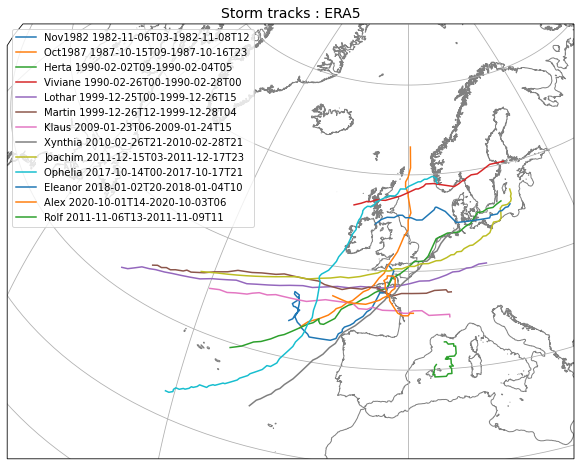

In [200]:
#projection=ccrs.PlateCarree()
projection=ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=45.0)
bounds = [(lonW, lonE, latS, latN)]
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', facecolor='none', name='coastline')
                             
fig = plt.figure(figsize=(12., 8.))
#fig.suptitle('Storm tracks : ERA5',fontsize=16)
ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.set_title('Storm tracks : ERA5',loc='center',fontsize=14)
ax.add_feature(coast, edgecolor='gray')
ax.gridlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
#ax.set_xticks(np.linspace(-180, 180, 37), crs=ccrs.PlateCarree())
#ax.set_yticks(np.linspace(-90, 90, 19), crs=ccrs.PlateCarree())
#lon_formatter = LongitudeFormatter(zero_direction_label=True)
#lat_formatter = LatitudeFormatter()
#ax.xaxis.set_major_formatter(lon_formatter)
#ax.yaxis.set_major_formatter(lat_formatter)

for storm in storms:
		
	#--  Open storm track file
	liste_time,liste_lon,liste_lat,liste_pres=np.loadtxt('./txt/'+storm+'.txt',skiprows=0, dtype='U13,float,float,int',unpack=True)
	date1=str(liste_time[0])
	date2=str(liste_time[-1])
	ax.plot(liste_lon,liste_lat, transform=ccrs.PlateCarree(), label=storm+' '+date1+'-'+date2)
	#ax.text(liste_lon[0]-1, liste_lat[0], storm, verticalalignment='center', horizontalalignment='right',transform=ccrs.PlateCarree()._as_mpl_transform(ax),
	#bbox=dict(alpha=0.1, boxstyle='round'))

ax.legend()
plt.show()

# Suivi d'une tempête

In [237]:
menu_options = {
    1: 'Option 1',
    2: 'Option 2',
    3: 'Option 3',
    4: 'Exit',
}

def print_menu():
    print ('1 -- Nov1982' )
    print ('2 -- Oct1987' )
    print ('3 -- Herta' )
    print ('4 -- Viviane' )
    print ('5 -- Lothar' )
    print ('6 -- Martin' )
    print ('7 -- Klaus' )
    print ('8 -- Xynthia' )
    print ('9 -- Joachim' )
    print ('10 -- Ophelia' )
    print ('11 -- Eleanor' )
    print ('12 -- Alex' )
    print ('13 -- Rolf' )

print_menu()

option = int(input('Enter number of the desired storm : ')) 
if option == 1:
    storm='Nov1982'
elif option == 2:
    storm='Oct1987'
elif option == 3:
    storm='Herta'
elif option == 4:
    storm='Viviane'
elif option == 5:
    storm='Lothar'
elif option == 6:
    storm='Martin'
elif option == 7:
    storm='Klaus'
elif option == 8:
    storm='Xynthia'
elif option == 9:
    storm='Joachim'
elif option == 10:
    storm='Ophelia'
elif option == 11:
    storm='Eleanor'
elif option == 12:
    storm='Alex'
elif option == 13:
    storm='Rolf'
else:
    print('Invalid option. Please enter a number between 1 and 12.')
    
if not os.path.exists('./anim/'+storm):
	os.mkdir('./anim/'+storm)

if not os.path.exists('./figs/'+storm):
	os.mkdir('./figs/'+storm)

if not os.path.exists('./figs/'+storm+'/MSL_tracking/'):
	os.mkdir('./figs/'+storm+'/MSL_tracking/')
    
dir_anim='./anim/'+storm+'/'

if storm=='Rolf':
    latS=35
    latN=50
    lonW=0
    lonE=15

1 -- Nov1982
2 -- Oct1987
3 -- Herta
4 -- Viviane
5 -- Lothar
6 -- Martin
7 -- Klaus
8 -- Xynthia
9 -- Joachim
10 -- Ophelia
11 -- Eleanor
12 -- Alex
13 -- Rolf
Enter number of the desired storm : 10


In [238]:
liste_time,liste_lon,liste_lat,liste_pres=np.loadtxt('./txt/'+storm+'.txt',
        skiprows=0, dtype='U13,float,float,int',unpack=True)
date1=str(liste_time[0])
date2=str(liste_time[-1])

In [239]:
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):

    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):
        #print('Low '+str(i+1))
        #print(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], int(data[mxy[i], mxx[i]]))
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=12,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
                '\n' + str(int(data[mxy[i], mxx[i]])),
                color=color, size=10, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)

In [240]:
def make_animation():
    nbimages=len(time)
    # create a tuple of display durations, one for each frame
    first_last = 1000 #show the first and last frames for 1000 ms
    standard_duration = 1000 #show all other frames for 1000 ms
    durations = tuple([first_last] + [standard_duration] * (nbimages - 2) + [first_last])
    # load all the static images into a list
    images = [Image.open(image) for image in sorted(glob.glob('{}/*.png'.format(dir_anim)))]
    # save as an animated gif
    gif = images[0]
    gif.info['duration'] = durations #ms per frame
    gif.info['loop'] = 0 #how many times to loop (0=infinite)
    gif.save(fp=gif_filepath, format='gif', save_all=True, append_images=images[1:])
    # verify that the number of frames in the gif equals the number of image files and durations
    Image.open(gif_filepath).n_frames == len(images) == len(durations)
    # clean png
    os.chdir(dir_anim)
    for f in glob.glob("*.png"):
        os.remove(f)
    os.chdir("../../")
    return Image

In [241]:
def make_animation2():
    nbimages=len(time)-1
    # create a tuple of display durations, one for each frame
    first_last = 1000 #show the first and last frames for 1000 ms
    standard_duration = 1000 #show all other frames for 1000 ms
    durations = tuple([first_last] + [standard_duration] * (nbimages - 2) + [first_last])
    # load all the static images into a list
    images = [Image.open(image) for image in sorted(glob.glob('{}/*.png'.format(dir_anim)))]
    # save as an animated gif
    gif = images[0]
    gif.info['duration'] = durations #ms per frame
    gif.info['loop'] = 0 #how many times to loop (0=infinite)
    gif.save(fp=gif_filepath, format='gif', save_all=True, append_images=images[1:])
    # verify that the number of frames in the gif equals the number of image files and durations
    Image.open(gif_filepath).n_frames == len(images) == len(durations)
    # clean png
    os.chdir(dir_anim)
    for f in glob.glob("*.png"):
        os.remove(f)
    os.chdir("../../")
    return Image

In [242]:
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1 = np.deg2rad(lon1)
    lon2 = np.deg2rad(lon2)
    lat1 = np.deg2rad(lat1)
    lat2 = np.deg2rad(lat2)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371
    return c * r

In [243]:
def get_bearing(lat1, lon1, lat2, lon2):
    dLon = (lon2 - lon1)
    x = math.cos(math.radians(lat2)) * math.sin(math.radians(dLon))
    y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(dLon))
    brng = np.arctan2(x,y)
    brng = np.degrees(brng)
    brng = (brng +360) % 360
    return brng

In [244]:
f1    = xr.open_dataset("./data/"+storm+"/msl.nc").sel(
    time=slice(date1,date2)).sel(
    latitude=slice(latN,latS)).sel(
    longitude=slice(lonW,lonE))

mslp = f1['msl']/100
lat  = mslp.latitude.values
time  = mslp.time.values
lon  = mslp.longitude.values

print(mslp)

<xarray.DataArray 'msl' (time: 94, latitude: 161, longitude: 321)>
array([[[1010.01227, 1009.91986, 1009.8274 , ..., 1000.3402 ,
         1000.61755, 1000.8822 ],
        [1010.1498 , 1010.05273, 1009.9626 , ..., 1001.067  ,
         1001.33044, 1001.56274],
        [1010.3127 , 1010.21216, 1010.11505, ..., 1002.31256,
         1002.58295, 1002.84985],
        ...,
        [1020.3429 , 1020.3325 , 1020.30475, ..., 1021.1956 ,
         1021.2025 , 1021.1852 ],
        [1020.19037, 1020.1754 , 1020.1499 , ..., 1021.2244 ,
         1021.1621 , 1021.10205],
        [1020.0355 , 1020.017  , 1019.9847 , ..., 1021.23486,
         1021.0697 , 1020.96216]],

       [[1010.3173 , 1010.2226 , 1010.1301 , ..., 1000.3125 ,
         1000.5101 , 1000.69037],
        [1010.4074 , 1010.315  , 1010.22485, ..., 1001.0427 ,
         1001.2126 , 1001.33966],
        [1010.5299 , 1010.4375 , 1010.3427 , ..., 1002.2156 ,
         1002.38763, 1002.5598 ],
...
        [1019.2684 , 1019.4255 , 1019.57794, ..., 

In [245]:
#mslp_filter = gaussian_filter(mslp, sigma=3.0)

In [246]:
lon_grid, lat_grid = np.meshgrid(lon, lat)

In [247]:
f2    = xr.open_dataset("./data/"+storm+"/z.nc").sel(
    time=slice(date1,date2)).sel(
    latitude=slice(latN,latS)).sel(
    longitude=slice(lonW,lonE))

lev = f2.level.values

z = f2['z']/9.81

thickness=z.sel(level=600)-z.sel(level=900)
print(z)
print(thickness)
print(np.min(thickness))
print(np.max(thickness))

<xarray.DataArray 'z' (time: 94, level: 27, latitude: 161, longitude: 321)>
array([[[[ 1.58135820e+04,  1.58141016e+04,  1.58146211e+04, ...,
           1.60756201e+04,  1.60756201e+04,  1.60756201e+04],
         [ 1.58164365e+04,  1.58166943e+04,  1.58172139e+04, ...,
           1.60787344e+04,  1.60787344e+04,  1.60787344e+04],
         [ 1.58190293e+04,  1.58195488e+04,  1.58200684e+04, ...,
           1.60818486e+04,  1.60818486e+04,  1.60818486e+04],
         ...,
         [ 1.65555938e+04,  1.65553359e+04,  1.65553359e+04, ...,
           1.65148594e+04,  1.65158984e+04,  1.65169375e+04],
         [ 1.65574082e+04,  1.65571504e+04,  1.65571504e+04, ...,
           1.65190117e+04,  1.65200488e+04,  1.65210879e+04],
         [ 1.65592266e+04,  1.65589668e+04,  1.65589668e+04, ...,
           1.65229023e+04,  1.65239414e+04,  1.65249805e+04]],

        [[ 1.43588779e+04,  1.43593955e+04,  1.43599141e+04, ...,
           1.46577559e+04,  1.46580156e+04,  1.46580156e+04],
         [ 1

In [248]:
#z_filter = gaussian_filter(z, sigma=3.0)

In [251]:
mslp_levels = np.arange(900,1072,2)
#dz_levels = np.arange(3000,3525,25)
dz_levels=np.linspace(np.min(thickness),np.max(thickness),20)

projection=ccrs.PlateCarree()
bounds = [(lonW, lonE, latS, latN)]
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

for i in range(len(time)):
    print(str(time[i])[0:13])
    fig = plt.figure(figsize=(17., 12.))
    #fig.suptitle('Storm '+storm+' - Mean Sea level Pressure and tracking',fontsize=16)
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_title('Storm '+storm+' - MSLP tracking and 600-300hPa thickness',loc='left',fontsize=14)
    ax.set_title(str(time[i])[0:13],loc='right',fontsize=14)
    #ax.coastlines()
    ax.add_feature(coast, edgecolor='gray')
    ax.set_xticks(np.linspace(-180, 180, 37), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(-90, 90, 19), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    
    # MSLP in contours and min max
    c1 = ax.contour(lon, lat, mslp[i,:,:], levels=mslp_levels, 
                    colors="black", linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(c1,fmt='%4.1i',fontsize=10)
    ax.scatter(liste_lon[i],liste_lat[i], c='green', transform=ccrs.PlateCarree())
    ax.plot(liste_lon[0:i+1],liste_lat[0:i+1], c='red', marker='+', transform=ccrs.PlateCarree())
    #plot_maxmin_points(lon_grid, lat_grid, mslp[i,:,:], 'max', 25,
    #symbol='H', color='r',  transform=ccrs.PlateCarree())
    plot_maxmin_points(lon_grid, lat_grid, mslp[i,:,:], 'min', 25,
                       symbol='L', color='b', transform=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, thickness[i,:,:], levels=dz_levels, 
                     cmap='jet', transform=ccrs.PlateCarree())
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=0.5, pad=0.1)
    cb.set_label('m')
    #plt.show()
    figname='./anim/'+storm+'/MSL_tracking_'+str(time[i])[0:13]
    fig.savefig(figname+'.png',bbox_inches='tight')
    plt.close()

2017-10-14T00
2017-10-14T01
2017-10-14T02
2017-10-14T03
2017-10-14T04
2017-10-14T05
2017-10-14T06
2017-10-14T07
2017-10-14T08
2017-10-14T09
2017-10-14T10
2017-10-14T11
2017-10-14T12
2017-10-14T13
2017-10-14T14
2017-10-14T15
2017-10-14T16
2017-10-14T17
2017-10-14T18
2017-10-14T19
2017-10-14T20
2017-10-14T21
2017-10-14T22
2017-10-14T23
2017-10-15T00
2017-10-15T01
2017-10-15T02
2017-10-15T03
2017-10-15T04
2017-10-15T05
2017-10-15T06
2017-10-15T07
2017-10-15T08
2017-10-15T09
2017-10-15T10
2017-10-15T11
2017-10-15T12
2017-10-15T13
2017-10-15T14
2017-10-15T15
2017-10-15T16
2017-10-15T17
2017-10-15T18
2017-10-15T19
2017-10-15T20
2017-10-15T21
2017-10-15T22
2017-10-15T23
2017-10-16T00
2017-10-16T01
2017-10-16T02
2017-10-16T03
2017-10-16T04
2017-10-16T05
2017-10-16T06
2017-10-16T07
2017-10-16T08
2017-10-16T09
2017-10-16T10
2017-10-16T11
2017-10-16T12
2017-10-16T13
2017-10-16T14
2017-10-16T15
2017-10-16T16
2017-10-16T17
2017-10-16T18
2017-10-16T19
2017-10-16T20
2017-10-16T21
2017-10-16T22
2017-1

In [252]:
gif_filepath = './anim/'+storm+'/MSL_tracking.gif'
make_animation()
IPdisplay.Image(url=gif_filepath)

In [253]:
for i in range(len(time)):
    print(str(time[i])[0:13])
    data_slp = mslp[i,:,:]
    data_thickness = thickness[i,:,:]
        
    # Center coordinates
    clat = liste_lat[i]
    clon = liste_lon[i] 
    max_dist = 500      # max distance in km
    if storm=='Rolf':
        max_dist = 250
    # Calculate distance between center and all other lat/lon pairs
    distance = haversine(lon[:,np.newaxis], lat, clon, clat)
    distance2=np.transpose(distance)
    # Mask distance array where distance > max_dist
    distance_m = np.ma.masked_greater(distance2, max_dist)
    # Mask the data array based on the distance mask
    data_slp_m = np.ma.masked_where(distance2 > max_dist, data_slp)
    data_thickness_m = np.ma.masked_where(distance2 > max_dist, data_thickness)

    
    fig = plt.figure(figsize=(17., 12.))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_title('Storm '+storm+' - MSLP tracking and 600-300hPa thickness',loc='left',fontsize=14)
    ax.set_title(str(time[i])[0:13],loc='right',fontsize=14)
    #ax.coastlines()
    ax.add_feature(coast, edgecolor='gray')
    ax.set_xticks(np.linspace(-180, 180, 37), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(-90, 90, 19), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    # MSLP in contours and min max
    c1 = ax.contour(lon, lat, data_slp_m, levels=mslp_levels,
                    colors="black", linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(c1,fmt='%4.1i',fontsize=10)
    ax.scatter(liste_lon[i],liste_lat[i], c='green', transform=ccrs.PlateCarree())
    ax.plot(liste_lon[0:i+1],liste_lat[0:i+1], c='red', marker='+', transform=ccrs.PlateCarree())
    cf = ax.contourf(lon, lat, data_thickness_m, levels=dz_levels, 
                     cmap='jet', transform=ccrs.PlateCarree())
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=0.5, pad=0.1)
    cb.set_label('m')
    #plt.show()
    figname='./anim/'+storm+'/MSL_tracking_zoom_'+str(time[i])[0:13]
    fig.savefig(figname+'.png',bbox_inches='tight')
    plt.close()

2017-10-14T00
2017-10-14T01
2017-10-14T02
2017-10-14T03
2017-10-14T04
2017-10-14T05
2017-10-14T06
2017-10-14T07
2017-10-14T08
2017-10-14T09
2017-10-14T10
2017-10-14T11
2017-10-14T12
2017-10-14T13
2017-10-14T14
2017-10-14T15
2017-10-14T16
2017-10-14T17
2017-10-14T18
2017-10-14T19
2017-10-14T20
2017-10-14T21
2017-10-14T22
2017-10-14T23
2017-10-15T00
2017-10-15T01
2017-10-15T02
2017-10-15T03
2017-10-15T04
2017-10-15T05
2017-10-15T06
2017-10-15T07
2017-10-15T08
2017-10-15T09
2017-10-15T10
2017-10-15T11
2017-10-15T12
2017-10-15T13
2017-10-15T14
2017-10-15T15
2017-10-15T16
2017-10-15T17
2017-10-15T18
2017-10-15T19
2017-10-15T20
2017-10-15T21
2017-10-15T22
2017-10-15T23
2017-10-16T00
2017-10-16T01
2017-10-16T02
2017-10-16T03
2017-10-16T04
2017-10-16T05
2017-10-16T06
2017-10-16T07
2017-10-16T08
2017-10-16T09
2017-10-16T10
2017-10-16T11
2017-10-16T12
2017-10-16T13
2017-10-16T14
2017-10-16T15
2017-10-16T16
2017-10-16T17
2017-10-16T18
2017-10-16T19
2017-10-16T20
2017-10-16T21
2017-10-16T22
2017-1

In [254]:
gif_filepath = './anim/'+storm+'/MSL_tracking_zoom.gif'
make_animation()
IPdisplay.Image(url=gif_filepath)

In [255]:
max_dist = 500
if storm=='Rolf':
    max_dist = 250
if storm=='Lothar':
    max_dist = 500

# Calcul du paramètre de symétrie thermique du CPS

In [256]:
i=10

data = thickness[i,:,:]
data_slp = mslp[i,:,:]

In [257]:
ang=get_bearing(clat, clon, liste_lat[i+1], liste_lon[i+1])

In [258]:
qq_ang_all=np.zeros([len(lon),len(lat)],dtype='f')
for x in range(0,len(lon)):
    for y in range(0,len(lat)):
        qq_ang_all[x,y]=get_bearing(clat, clon, lat[y], lon[x])     
qq_ang_all=np.transpose(qq_ang_all)

In [259]:
Zl=np.zeros([len(lat),len(lon)],dtype='f')
Zr=np.zeros([len(lat),len(lon)],dtype='f')

for jlat in range(0,len(lat)-1):
    for jlon in range(0,len(lon)-1):
        #set values along great circle line to missing (neither left nor right)
        if qq_ang_all[jlat,jlon] == ang:
            Zl[jlat,jlon] = 0
            Zr[jlat,jlon] = 0
        #for storm travel angles in quadrants 1 and 2 (NE and SE)
        elif (ang >= 0 and ang < 180):
            if (qq_ang_all[jlat,jlon] > ang and qq_ang_all[jlat,jlon]  < ang+180):
                Zl[jlat,jlon] = 0
                Zr[jlat,jlon] = data[jlat,jlon]
            else:
                Zr[jlat,jlon] = 0
                Zl[jlat,jlon] = data[jlat,jlon]
        #for storm travel angles in quadrants 3 and 4 (NW and SW)
        elif (ang >= 180 and ang < 360):
            if (qq_ang_all[jlat,jlon] > ang-180 and qq_ang_all[jlat,jlon] < ang):
                Zr[jlat,jlon] = 0
                Zl[jlat,jlon] = data[jlat,jlon]
            else:
                Zl[jlat,jlon] = 0
                Zr[jlat,jlon] = data[jlat,jlon]

In [260]:
# Calculate distance between center and all other lat/lon pairs
distance = haversine(lon[:,np.newaxis], lat, clon, clat)
distance2=np.transpose(distance)
# Mask distance array where distance > max_dist
distance_m = np.ma.masked_greater(distance2, max_dist)
# Mask the data array based on the distance mask
data_slp_m = np.ma.masked_where(distance2 > max_dist, data_slp)
Zr_m = np.ma.masked_where(distance2 > max_dist, Zr)
Zl_m = np.ma.masked_where(distance2 > max_dist, Zl)

Zr_m[Zr_m == 0] = np.nan
Zl_m[Zl_m == 0] = np.nan

In [261]:
# cyclone thermal symmetry parameter using classic average
#Zr_mean=np.nanmean(Zr_m)
#Zl_mean=np.nanmean(Zl_m)
#B=Zr_mean-Zl_mean
#print(Zr_mean)
#print(Zl_mean)

# cyclone thermal symmetry parameter using weighted average
Zr_m = xr.DataArray(Zr_m)
Zl_m = xr.DataArray(Zl_m)
weights = xr.DataArray(np.cos(np.deg2rad(Zr_m.shape[0])))
Zr_weighted = Zr_m.weighted(weights)
Zl_weighted = Zl_m.weighted(weights)
Zr_weighted_mean=Zr_weighted.mean()
Zl_weighted_mean=Zl_weighted.mean()
B=Zr_weighted_mean-Zl_weighted_mean

print(Zr_weighted_mean)
print(Zl_weighted_mean)

if clat<0:
    B=-B

print(B)

<xarray.DataArray ()>
array(3191.09322711)
<xarray.DataArray ()>
array(3272.84674571)
<xarray.DataArray ()>
array(-81.7535186)


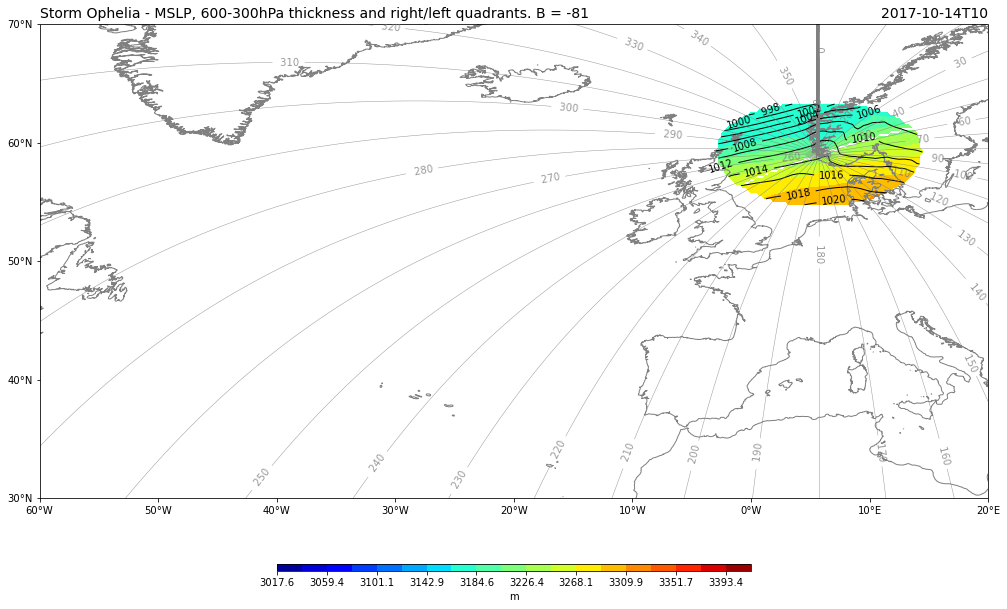

In [262]:
levels=np.arange(0,370,10)

fig = plt.figure(figsize=(17., 12.))
ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.set_title('Storm '+storm+' - MSLP, 600-300hPa thickness and right/left quadrants. B = '+str(int(B))
             ,loc='left',fontsize=14)
ax.set_title(str(time[i])[0:13],loc='right',fontsize=14)
#ax.coastlines()
ax.add_feature(coast, edgecolor='gray')
ax.set_xticks(np.linspace(-180, 180, 37), crs=ccrs.PlateCarree())
ax.set_yticks(np.linspace(-90, 90, 19), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
 
c0 = ax.contour(lon, lat, data_slp_m, mslp_levels,
                colors="black", linewidths=1, transform=ccrs.PlateCarree())
ax.clabel(c0,fmt='%4.1i',fontsize=10)
cf1 = ax.contourf(lon, lat, Zr_m, dz_levels,
                 cmap='jet', transform=ccrs.PlateCarree())
cf2 = ax.contourf(lon, lat, Zl_m, dz_levels,
                 cmap='jet', transform=ccrs.PlateCarree())
cb = fig.colorbar(cf1, orientation='horizontal', aspect=65, shrink=0.5, pad=0.1)
cb.set_label('m')
c3 = ax.contour(lon, lat, qq_ang_all, levels,
                colors="grey", linewidths=0.5, alpha=0.8, transform=ccrs.PlateCarree())
ax.clabel(c3,fmt='%4.1i',fontsize=10)

plt.show()

In [263]:
B_series=[]

for i in range(len(time)-1):
    print(str(time[i])[0:13])
    data = thickness[i,:,:]
    data_slp = mslp[i,:,:]

    # Center coordinates
    clat = liste_lat[i]
    clon = liste_lon[i]

    # Calculate bearing between center and all other lat/lon pairs
    qq_ang_all=np.zeros([len(lon),len(lat)],dtype='f')
    for x in range(0,len(lon)):
        for y in range(0,len(lat)):
            qq_ang_all[x,y]=get_bearing(clat, clon, lat[y], lon[x])     
    qq_ang_all=np.transpose(qq_ang_all)

    # Angle of travel of the center
    ang=get_bearing(clat, clon, liste_lat[i+1], liste_lon[i+1])

    # Define right/left cadrans
    Zl=np.zeros([len(lat),len(lon)],dtype='f')
    Zr=np.zeros([len(lat),len(lon)],dtype='f')

    for jlat in range(0,len(lat)-1):
        for jlon in range(0,len(lon)-1):
            #set values along great circle line to missing (neither left nor right)
            if qq_ang_all[jlat,jlon] == ang:
                Zl[jlat,jlon] = 0
                Zr[jlat,jlon] = 0
            #for storm travel angles in quadrants 1 and 2 (NE and SE)
            elif (ang >= 0 and ang < 180):
                if (qq_ang_all[jlat,jlon] > ang and qq_ang_all[jlat,jlon]  < ang+180):
                    Zl[jlat,jlon] = 0
                    Zr[jlat,jlon] = data[jlat,jlon]
                else:
                    Zr[jlat,jlon] = 0
                    Zl[jlat,jlon] = data[jlat,jlon]
            #for storm travel angles in quadrants 3 and 4 (NW and SW)
            elif (ang >= 180 and ang < 360):
                if (qq_ang_all[jlat,jlon] > ang-180 and qq_ang_all[jlat,jlon] < ang):
                    Zr[jlat,jlon] = 0
                    Zl[jlat,jlon] = data[jlat,jlon]
                else:
                    Zl[jlat,jlon] = 0
                    Zr[jlat,jlon] = data[jlat,jlon]

    # Calculate distance between center and all other lat/lon pairs
    distance = haversine(lon[:,np.newaxis], lat, clon, clat)
    distance2=np.transpose(distance)
    # Mask distance array where distance > max_dist
    distance_m = np.ma.masked_greater(distance2, max_dist)
    # Mask the data array based on the distance mask
    data_slp_m = np.ma.masked_where(distance2 > max_dist, data_slp)
    Zr_m = np.ma.masked_where(distance2 > max_dist, Zr)
    Zl_m = np.ma.masked_where(distance2 > max_dist, Zl)
    
    Zr_m[Zr_m == 0] = np.nan
    Zl_m[Zl_m == 0] = np.nan

    # cyclone thermal symmetry parameter using weighted average
    #Zr_mean=np.nanmean(Zr_m)
    #Zl_mean=np.nanmean(Zl_m)
    #B=Zr_mean-Zl_mean

    Zr_m = xr.DataArray(Zr_m)
    Zl_m = xr.DataArray(Zl_m)
    weights = xr.DataArray(np.cos(np.deg2rad(Zr_m.shape[0])))
    Zr_weighted = Zr_m.weighted(weights)
    Zl_weighted = Zl_m.weighted(weights)
    Zr_weighted_mean=Zr_weighted.mean()
    Zl_weighted_mean=Zl_weighted.mean()
    B=int(Zr_weighted_mean-Zl_weighted_mean)

    if clat<0:
        B=-B
    #print('B = ',B)
    
    B_series.append(B)

    fig = plt.figure(figsize=(17., 12.))
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_title('Storm '+storm+' - MSLP, 600-300hPa thickness and right/left quadrants. B = '+str(int(B))
                 ,loc='left',fontsize=14)
    ax.set_title(str(time[i])[0:13],loc='right',fontsize=14)
    #ax.coastlines()
    ax.add_feature(coast, edgecolor='gray')
    ax.set_xticks(np.linspace(-180, 180, 37), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(-90, 90, 19), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())

    c0 = ax.contour(lon, lat, data_slp_m, mslp_levels,
                    colors="black", linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(c0,fmt='%4.1i',fontsize=10)
    cf1 = ax.contourf(lon, lat, Zr_m, dz_levels,
                     cmap='jet', transform=ccrs.PlateCarree())
    cf2 = ax.contourf(lon, lat, Zl_m, dz_levels,
                     cmap='jet', transform=ccrs.PlateCarree())
    cb = fig.colorbar(cf1, orientation='horizontal', aspect=65, shrink=0.5, pad=0.1)
    cb.set_label('m')
    c3 = ax.contour(lon, lat, qq_ang_all, levels,
                    colors="grey", linewidths=0.5, alpha=0.8, transform=ccrs.PlateCarree())
    ax.clabel(c3,fmt='%4.1i',fontsize=10)

    #plt.show()
    figname='./anim/'+storm+'/Thermal_symmetry_'+str(time[i])[0:13]
    fig.savefig(figname+'.png',bbox_inches='tight')
    plt.close()

2017-10-14T00
2017-10-14T01
2017-10-14T02
2017-10-14T03
2017-10-14T04
2017-10-14T05
2017-10-14T06
2017-10-14T07
2017-10-14T08
2017-10-14T09
2017-10-14T10
2017-10-14T11
2017-10-14T12
2017-10-14T13
2017-10-14T14
2017-10-14T15
2017-10-14T16
2017-10-14T17
2017-10-14T18
2017-10-14T19
2017-10-14T20
2017-10-14T21
2017-10-14T22
2017-10-14T23
2017-10-15T00
2017-10-15T01
2017-10-15T02
2017-10-15T03
2017-10-15T04
2017-10-15T05
2017-10-15T06
2017-10-15T07
2017-10-15T08
2017-10-15T09
2017-10-15T10
2017-10-15T11
2017-10-15T12
2017-10-15T13
2017-10-15T14
2017-10-15T15
2017-10-15T16
2017-10-15T17
2017-10-15T18
2017-10-15T19
2017-10-15T20
2017-10-15T21
2017-10-15T22
2017-10-15T23
2017-10-16T00
2017-10-16T01
2017-10-16T02
2017-10-16T03
2017-10-16T04
2017-10-16T05
2017-10-16T06
2017-10-16T07
2017-10-16T08
2017-10-16T09
2017-10-16T10
2017-10-16T11
2017-10-16T12
2017-10-16T13
2017-10-16T14
2017-10-16T15
2017-10-16T16
2017-10-16T17
2017-10-16T18
2017-10-16T19
2017-10-16T20
2017-10-16T21
2017-10-16T22
2017-1

In [264]:
gif_filepath = './anim/'+storm+'/Thermal_symmetry.gif'
make_animation2()
IPdisplay.Image(url=gif_filepath)

[4, 4, 0, -6, 0, 7, 7, 5, 7, 5, 8, 14, 14, 14, 17, 17, 14, 20, 18, 20, 21, 18, 27, 28, 29, 29, 34, 35, 35, 38, 38, 37, 39, 29, 38, 39, 48, 53, 57, 62, 70, 73, 79, 83, 85, 93, 94, 99, 99, 81, 93, 60, 30, 26, 44, 42, 51, 39, 34, 41, 43, 43, 38, 41, 39, 37, 37, 33, 35, 31, 11, 10, 27, 33, 27, 31, 28, 36, 36, 36, 37, 39, 19, 38, 36, 35, 34, 34, 2, 36, 33, -16, 24]


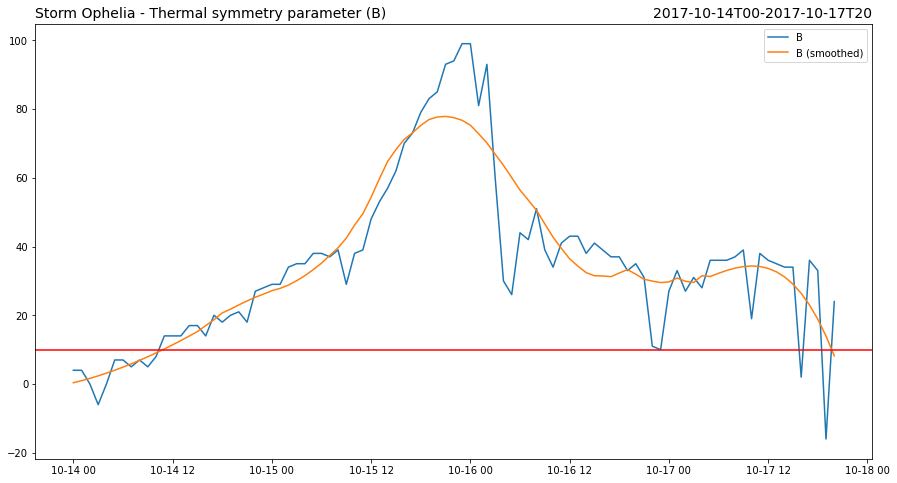

In [265]:
print(B_series)
B_series2 = savgol_filter(B_series, 31, 3)

fig = plt.figure(figsize=(15., 8.))
ax = fig.add_subplot(111)
ax.set_title('Storm '+storm+' - Thermal symmetry parameter (B)'
             ,loc='left',fontsize=14)
ax.set_title(str(time[0])[0:13]+'-'+str(time[-2])[0:13],loc='right',fontsize=14)
ax.plot(time[0:-1], B_series, label='B')
ax.plot(time[0:-1], B_series2, label='B (smoothed)')
plt.axhline(y=10, color='r')
plt.legend()

figname='./figs/'+storm+'/Thermal_symmetry_timeseries'
fig.savefig(figname+'.png',bbox_inches='tight')

# Calcul du paramètre de coeur chaud/coeur froid du CPS

In [266]:
i=10

print(lev)
listlev1=[900, 850, 800, 750, 700, 650, 600]
listlev11=[n * 100 for n in listlev1]
lnP1=np.log(listlev11)
listlev2=[600, 550, 500, 450, 400, 350, 300]
listlev22=[n * 100 for n in listlev2]
lnP2=np.log(listlev22)

[ 100  125  150  175  200  225  250  300  350  400  450  500  550  600
  650  700  750  775  800  825  850  875  900  925  950  975 1000]


In [267]:
deltaZ1=[]
deltaZ2=[]

for plev in listlev1:

    ilev = list(lev).index(plev)
    data_z1 = z[i,ilev,:,:]

    # Calculate distance between center and all other lat/lon pairs
    distance = haversine(lon[:,np.newaxis], lat, clon, clat)
    distance2=np.transpose(distance)
    # Mask distance array where distance > max_dist
    distance_m = np.ma.masked_greater(distance2, max_dist)
    # Mask the data array based on the distance mask
    data_z1_m = np.ma.masked_where(distance2 > max_dist, data_z1)
    zmin=np.min(data_z1_m)
    zmax=np.max(data_z1_m)
    delta_z1=zmax-zmin
    deltaZ1.append(int(delta_z1))

for plev in listlev2:

    ilev = list(lev).index(plev)
    data_z2 = z[i,ilev,:,:]

    # Calculate distance between center and all other lat/lon pairs
    distance = haversine(lon[:,np.newaxis], lat, clon, clat)
    distance2=np.transpose(distance)
    # Mask distance array where distance > max_dist
    distance_m = np.ma.masked_greater(distance2, max_dist)
    # Mask the data array based on the distance mask
    data_z2_m = np.ma.masked_where(distance2 > max_dist, data_z2)
    zmin=np.min(data_z2_m)
    zmax=np.max(data_z2_m)
    delta_z2=zmax-zmin
    deltaZ2.append(int(delta_z2))

In [268]:
X1 = np.reshape(lnP1, (len(lnP1), 1))
y1 =  deltaZ1
model = LinearRegression().fit(X1, y1)
model.fit(X1, y1)
yhat1 = model.predict(X1)
reg = LinearRegression().fit(X1, y1)
coef1=reg.coef_

X2 = np.reshape(lnP2, (len(lnP2), 1))
y2 =  deltaZ2
model = LinearRegression().fit(X2, y2)
model.fit(X2, y2)
yhat2 = model.predict(X2)
reg = LinearRegression().fit(X2, y2)
coef2=reg.coef_

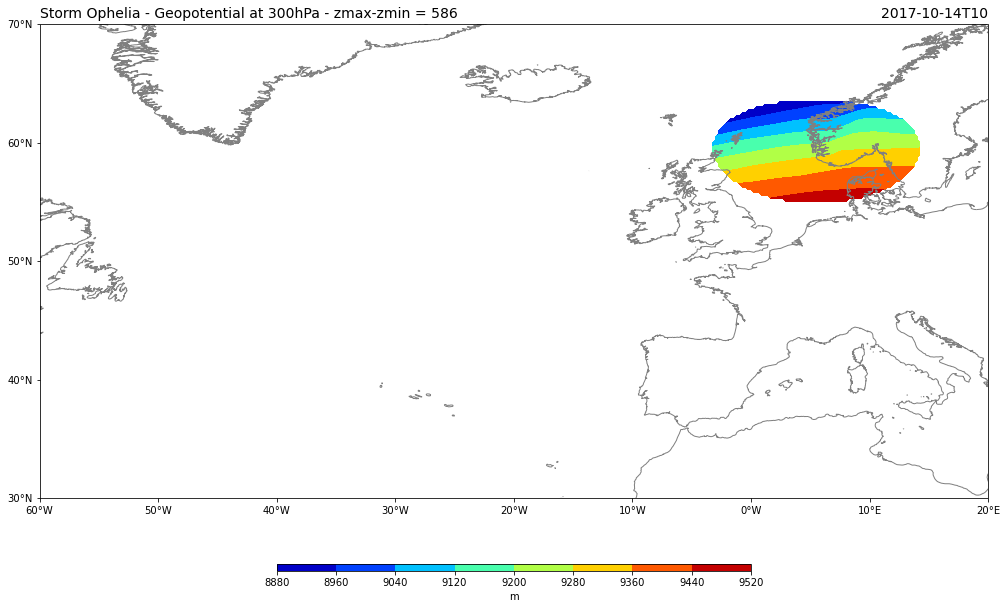

In [269]:
fig = plt.figure(figsize=(17., 12.))
ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.set_title('Storm '+storm+' - Geopotential at '+str(plev)+ 'hPa - zmax-zmin = '+str(int(delta_z2))
             ,loc='left',fontsize=14)
ax.set_title(str(time[i])[0:13],loc='right',fontsize=14)
#ax.coastlines()
ax.add_feature(coast, edgecolor='gray')
ax.set_xticks(np.linspace(-180, 180, 37), crs=ccrs.PlateCarree())
ax.set_yticks(np.linspace(-90, 90, 19), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
 
cf = ax.contourf(lon, lat, data_z2_m,
                     cmap='jet', transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=0.5, pad=0.1)
cb.set_label('m')

plt.show()

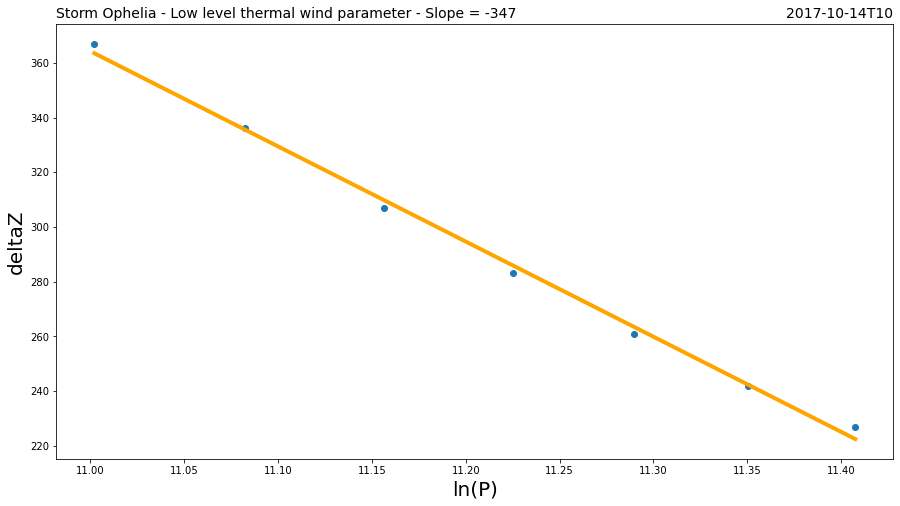

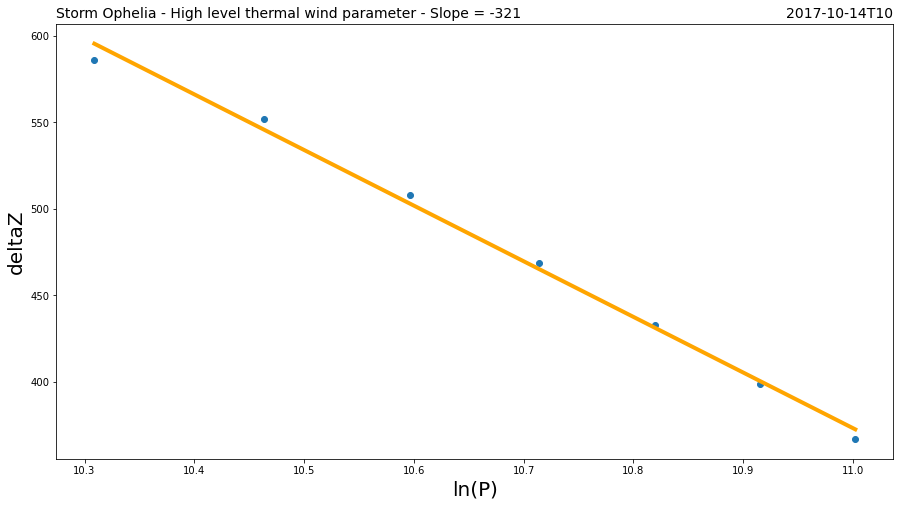

In [270]:
fig = plt.figure(figsize=(15., 8.))
ax = fig.add_subplot(111)
ax.set_title('Storm '+storm+' - Low level thermal wind parameter - Slope = '+str(int(coef1))
             ,loc='left',fontsize=14)
ax.set_title(str(time[i])[0:13],loc='right',fontsize=14)
plt.scatter(lnP1, deltaZ1)
plt.plot(lnP1,yhat1, lw=4, c="orange", label = "regression line")
plt.xlabel("ln(P)", fontsize = 20)
plt.ylabel("deltaZ", fontsize = 20)
 
plt.show()

fig = plt.figure(figsize=(15., 8.))
ax = fig.add_subplot(111)
ax.set_title('Storm '+storm+' - High level thermal wind parameter - Slope = '+str(int(coef2))
             ,loc='left',fontsize=14)
ax.set_title(str(time[i])[0:13],loc='right',fontsize=14)
plt.scatter(lnP2, deltaZ2)
plt.plot(lnP2,yhat2, lw=4, c="orange", label = "regression line")
plt.xlabel("ln(P)", fontsize = 20)
plt.ylabel("deltaZ", fontsize = 20)
 
plt.show()

In [271]:
VTL_series=[]
VTU_series=[]

for i in range(len(time)-1):
    print(str(time[i])[0:13])

    # Center coordinates
    clat = liste_lat[i]
    clon = liste_lon[i]
    deltaZ1=[]
    deltaZ2=[]

    for plev in listlev1:

        ilev = list(lev).index(plev)
        data_z1 = z[i,ilev,:,:]

        max_dist = 500      # max distance in km
        # Calculate distance between center and all other lat/lon pairs
        distance = haversine(lon[:,np.newaxis], lat, clon, clat)
        distance2=np.transpose(distance)
        # Mask distance array where distance > max_dist
        distance_m = np.ma.masked_greater(distance2, max_dist)
        # Mask the data array based on the distance mask
        data_z1_m = np.ma.masked_where(distance2 > max_dist, data_z1)
        zmin=np.min(data_z1_m)
        zmax=np.max(data_z1_m)
        delta_z1=zmax-zmin
        deltaZ1.append(int(delta_z1))

    for plev in listlev2:

        ilev = list(lev).index(plev)
        data_z2 = z[i,ilev,:,:]

        # Calculate distance between center and all other lat/lon pairs
        distance = haversine(lon[:,np.newaxis], lat, clon, clat)
        distance2=np.transpose(distance)
        # Mask distance array where distance > max_dist
        distance_m = np.ma.masked_greater(distance2, max_dist)
        # Mask the data array based on the distance mask
        data_z2_m = np.ma.masked_where(distance2 > max_dist, data_z2)
        zmin=np.min(data_z2_m)
        zmax=np.max(data_z2_m)
        delta_z2=zmax-zmin
        deltaZ2.append(int(delta_z2))

    X1 = np.reshape(lnP1, (len(lnP1), 1))
    y1 =  deltaZ1
    model = LinearRegression().fit(X1, y1)
    model.fit(X1, y1)
    yhat1 = model.predict(X1)
    reg = LinearRegression().fit(X1, y1)
    coef1=reg.coef_
    VTL_series.append(int(coef1))

    X2 = np.reshape(lnP2, (len(lnP2), 1))
    y2 =  deltaZ2
    model = LinearRegression().fit(X2, y2)
    model.fit(X2, y2)
    yhat2 = model.predict(X2)
    reg = LinearRegression().fit(X2, y2)
    coef2=reg.coef_
    VTU_series.append(int(coef2))

2017-10-14T00
2017-10-14T01
2017-10-14T02
2017-10-14T03
2017-10-14T04
2017-10-14T05
2017-10-14T06
2017-10-14T07
2017-10-14T08
2017-10-14T09
2017-10-14T10
2017-10-14T11
2017-10-14T12
2017-10-14T13
2017-10-14T14
2017-10-14T15
2017-10-14T16
2017-10-14T17
2017-10-14T18
2017-10-14T19
2017-10-14T20
2017-10-14T21
2017-10-14T22
2017-10-14T23
2017-10-15T00
2017-10-15T01
2017-10-15T02
2017-10-15T03
2017-10-15T04
2017-10-15T05
2017-10-15T06
2017-10-15T07
2017-10-15T08
2017-10-15T09
2017-10-15T10
2017-10-15T11
2017-10-15T12
2017-10-15T13
2017-10-15T14
2017-10-15T15
2017-10-15T16
2017-10-15T17
2017-10-15T18
2017-10-15T19
2017-10-15T20
2017-10-15T21
2017-10-15T22
2017-10-15T23
2017-10-16T00
2017-10-16T01
2017-10-16T02
2017-10-16T03
2017-10-16T04
2017-10-16T05
2017-10-16T06
2017-10-16T07
2017-10-16T08
2017-10-16T09
2017-10-16T10
2017-10-16T11
2017-10-16T12
2017-10-16T13
2017-10-16T14
2017-10-16T15
2017-10-16T16
2017-10-16T17
2017-10-16T18
2017-10-16T19
2017-10-16T20
2017-10-16T21
2017-10-16T22
2017-1

[65, 65, 63, 59, 53, 54, 50, 42, 44, 42, 41, 53, 49, 54, 52, 47, 42, 51, 74, 74, 96, 109, 103, 85, 94, 99, 100, 118, 127, 147, 160, 158, 143, 127, 127, 128, 118, 113, 99, 94, 81, 79, 80, 82, 75, 58, -19, -11, 13, 32, 46, 83, 84, 72, 64, 49, 30, 15, 78, 45, 20, -5, -6, -42, -23, -32, -21, -32, -32, -17, -32, -31, -27, -42, -51, -112, -148, -167, -159, -142, -142, -125, -124, -119, -122, -128, -141, -153, -166, -172, -194, -226, -230]
[85, 91, 88, 89, 73, 58, 64, 66, 66, 64, 79, 62, 61, 55, 25, 23, 46, 20, 4, 3, -7, -26, -25, -21, -24, -12, -13, -13, -24, -50, -53, -62, -66, -86, -85, -78, -110, -139, -150, -148, -163, -141, -154, -165, -146, -116, -51, -12, 8, 42, 54, 81, 104, 126, 120, 97, 77, 70, 71, 43, 35, 40, 30, 29, 38, 30, 48, 61, 61, 45, 17, -6, -21, -33, -46, -52, -47, -50, -56, -68, -81, -94, -133, -153, -191, -208, -230, -249, -282, -302, -310, -317, -313]


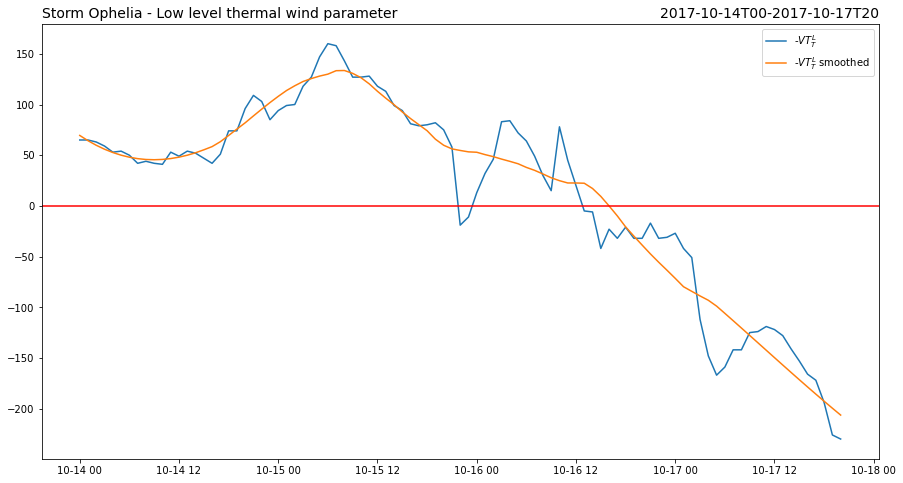

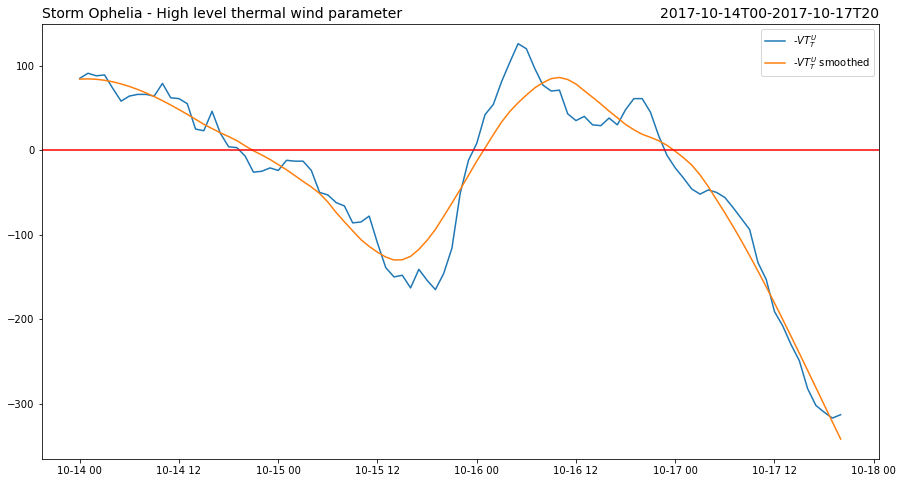

In [272]:
print(VTL_series)
print(VTU_series)
VTU_series2 = savgol_filter(VTU_series, 31, 3)
VTL_series2 = savgol_filter(VTL_series, 31, 3)

fig = plt.figure(figsize=(15., 8.))
ax = fig.add_subplot(111)
ax.set_title('Storm '+storm+' - Low level thermal wind parameter'
             ,loc='left',fontsize=14)
ax.set_title(str(time[0])[0:13]+'-'+str(time[-2])[0:13],loc='right',fontsize=14)
ax.plot(time[0:-1], VTL_series, label='-$VT_T^L$')
ax.plot(time[0:-1], VTL_series2, label='-$VT_T^L$ smoothed')
plt.axhline(y=0, color='r')
plt.legend()

plt.show()

figname='./figs/'+storm+'/VTL_timeseries'
fig.savefig(figname+'.png',bbox_inches='tight')

fig = plt.figure(figsize=(15., 8.))
ax = fig.add_subplot(111)
ax.set_title('Storm '+storm+' - High level thermal wind parameter'
             ,loc='left',fontsize=14)
ax.set_title(str(time[0])[0:13]+'-'+str(time[-2])[0:13],loc='right',fontsize=14)
ax.plot(time[0:-1], VTU_series, label='-$VT_T^U$')
ax.plot(time[0:-1], VTU_series2, label='-$VT_T^U$ smoothed')
plt.axhline(y=0, color='r')
plt.legend()

plt.show()

figname='./figs/'+storm+'/VTU_timeseries'
fig.savefig(figname+'.png',bbox_inches='tight')

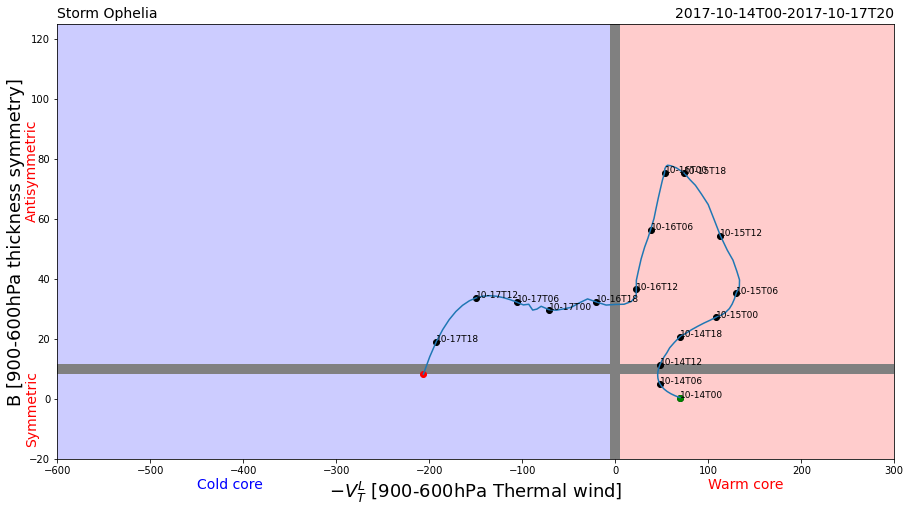

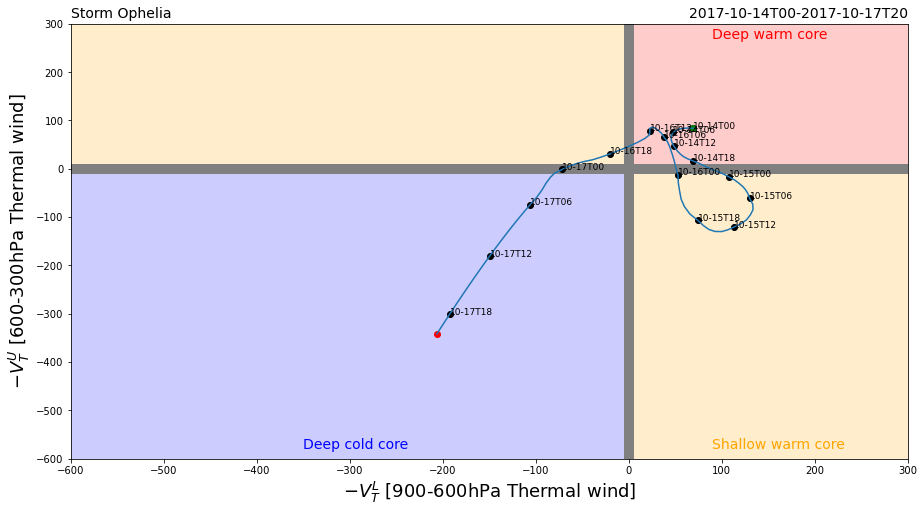

In [273]:
time_str=[x for x in range(len(time)-1)]
date_str=[x for x in range(len(time)-1)]
for i in range(len(time)-1):
    time_str[i] = str(time[i])
    date_str[i] = time_str[i][5:13]

step=6
newdate=date_str[0::step]
new_VTL=VTL_series2[0::step]
new_VTU=VTU_series2[0::step]
new_B=B_series2[0::step]

fig = plt.figure(figsize=(15., 8.))
ax = fig.add_subplot(111)
ax.set_title('Storm '+storm,loc='left',fontsize=14)
ax.set_title(str(time[0])[0:13]+'-'+str(time[-2])[0:13],loc='right',fontsize=14)
plt.axhline(y=10, color='grey', linewidth=10,zorder=1)
plt.axvline(x=0, color='grey', linewidth=10,zorder=1)
plt.plot(VTL_series2, B_series2)
plt.scatter(VTL_series2[::step],  B_series2[::step], c='k',zorder=2)
plt.scatter(VTL_series2[0], B_series2[0], c='green',zorder=2)
plt.scatter(VTL_series2[-1], B_series2[-1], c='red',zorder=2)
plt.xlabel("$-V_T^L$ [900-600hPa Thermal wind]", fontsize = 18)
plt.ylabel("B [900-600hPa thickness symmetry]", fontsize = 18)

plt.text(-635,-15,'Symmetric', rotation=90., color='red', fontsize = 14)
plt.text(-635, 60,'Antisymmetric', rotation=90., color='red', fontsize = 14)
plt.text(-450, -30,'Cold core', rotation=0., color='blue', fontsize = 14)
plt.text(100, -30,'Warm core', rotation=0., color='red', fontsize = 14)
plt.xlim(-600, 300)
plt.ylim(-20, 125)
    
for i,type in enumerate(newdate):
    x = new_VTL[i]
    y = new_B[i]
    plt.text(x, y, type, fontsize=9)
    
xrange = [(-600, 600)]
yrange1 = (-20, 30)
c1 = collections.BrokenBarHCollection(xrange, yrange1, facecolor='blue', alpha=0.2)
ax.add_collection(c1)
xrange = [(-600, 600)]
yrange1 = (10, 130)
c1 = collections.BrokenBarHCollection(xrange, yrange1, facecolor='blue', alpha=0.2)
ax.add_collection(c1)
xrange = [(0, 300)]
yrange1 = (-20, 30)
c1 = collections.BrokenBarHCollection(xrange, yrange1, facecolor='red', alpha=0.2)
ax.add_collection(c1)
xrange = [(0, 300)]
yrange1 = (10, 130)
c1 = collections.BrokenBarHCollection(xrange, yrange1, facecolor='red', alpha=0.2)
ax.add_collection(c1)

plt.show()

fig = plt.figure(figsize=(15., 8.))
ax = fig.add_subplot(111)
ax.set_title('Storm '+storm,loc='left',fontsize=14)
ax.set_title(str(time[0])[0:13]+'-'+str(time[-2])[0:13],loc='right',fontsize=14)
plt.axhline(y=0, color='grey', linewidth=10,zorder=1)
plt.axvline(x=0, color='grey', linewidth=10,zorder=1)
plt.plot(VTL_series2, VTU_series2)
plt.scatter(VTL_series2[::step], VTU_series2[::step], c='k',zorder=2)
plt.scatter(VTL_series2[0], VTU_series2[0], c='green',zorder=2)
plt.scatter(VTL_series2[-1], VTU_series2[-1], c='red',zorder=2)


plt.xlabel("$-V_T^L$ [900-600hPa Thermal wind]", fontsize = 18)
plt.ylabel("$-V_T^U$ [600-300hPa Thermal wind]", fontsize = 18)
plt.text(-350, -580,'Deep cold core', rotation=0., color='blue', fontsize = 14)
plt.text(90, 270,'Deep warm core', rotation=0., color='red', fontsize = 14)
plt.text(90, -580,'Shallow warm core', rotation=0., color='orange', fontsize = 14)

plt.xlim(-600, 300)
plt.ylim(-600, 300)

for i,type in enumerate(newdate):
    x = new_VTL[i]
    y = new_VTU[i]
    plt.text(x, y, type, fontsize=9)

xrange = [(0, 300)]
yrange1 = (0, 300)
c1 = collections.BrokenBarHCollection(xrange, yrange1, facecolor='r', alpha=0.2)
ax.add_collection(c1)
xrange = [(-600, 600)]
yrange1 = (-600, 600)
c1 = collections.BrokenBarHCollection(xrange, yrange1, facecolor='b', alpha=0.2)
ax.add_collection(c1)
xrange = [(-600, 600)]
yrange1 = (0, 300)
c1 = collections.BrokenBarHCollection(xrange, yrange1, facecolor='orange', alpha=0.2)
ax.add_collection(c1)
xrange = [(0, 300)]
yrange1 = (-600, 600)
c1 = collections.BrokenBarHCollection(xrange, yrange1, facecolor='orange', alpha=0.2)
ax.add_collection(c1)

plt.show()

figname='./figs/'+storm+'/CPS'
fig.savefig(figname+'.png',bbox_inches='tight')

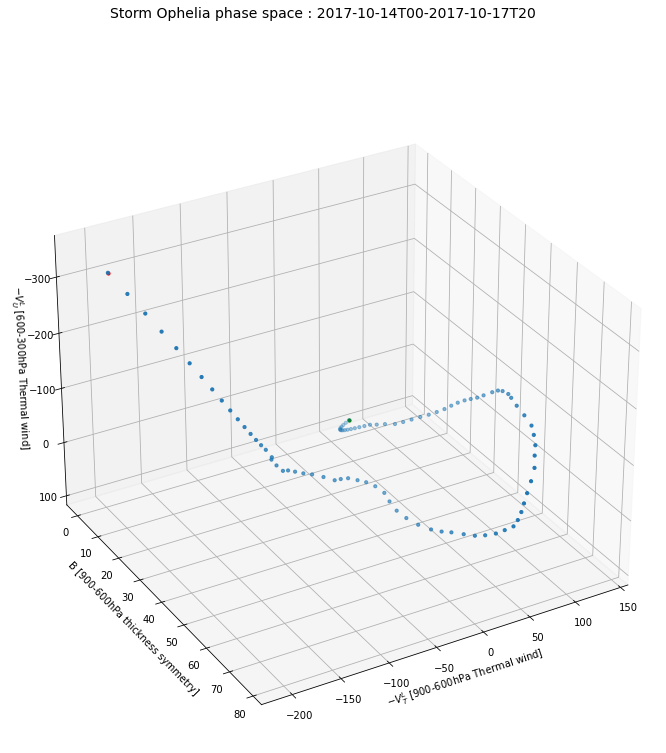

In [274]:
fig = plt.figure(figsize=(12, 12))
ax.set_title('Storm '+storm,loc='left',fontsize=14)

fig.suptitle('Storm '+storm+' phase space : '+str(time[0])[0:13]+'-'+str(time[-2])[0:13], fontsize=14)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("$-V_T^L$ [900-600hPa Thermal wind]")
ax.set_ylabel("B [900-600hPa thickness symmetry]")
ax.set_zlabel("$-V_U^L$ [600-300hPa Thermal wind]")
ax.scatter(VTL_series2, B_series2, VTU_series2, s=10)
ax.scatter(VTL_series2[0], B_series2[0], VTU_series2[0], c='green', s=10)
ax.scatter(VTL_series2[-1], B_series2[-1], VTU_series2[-1], c='red', s=10)
ax.view_init(-150, 300)
plt.show()
figname='./figs/'+storm+'/CPS_3d'
fig.savefig(figname+'.png',bbox_inches='tight')